In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from matplotlib import pyplot as plt

def to_image(o_tensor):
    o_img = o_tensor.cpu().clone()  # we clone the tensor to not do changes on it
    o_img = o_img.squeeze(0)  # remove the fake batch dimension
    o_img = torch.reshape(o_img, (3, 64, 64))
    for c in range(3): # Normalize to [0, 1.0]
        x_min, x_max = o_img[c].min(), o_img[c].max()
        o_img[c] = (o_img[c] - x_min) / (x_max-x_min)
    o_img = unloader(o_img)
    return o_img

class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(), 
            nn.Linear(256, 64), 
            nn.ReLU(), 
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(), 
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 64 * 64 * 3), 
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

a_tensor = torch.Size([1, 12288])


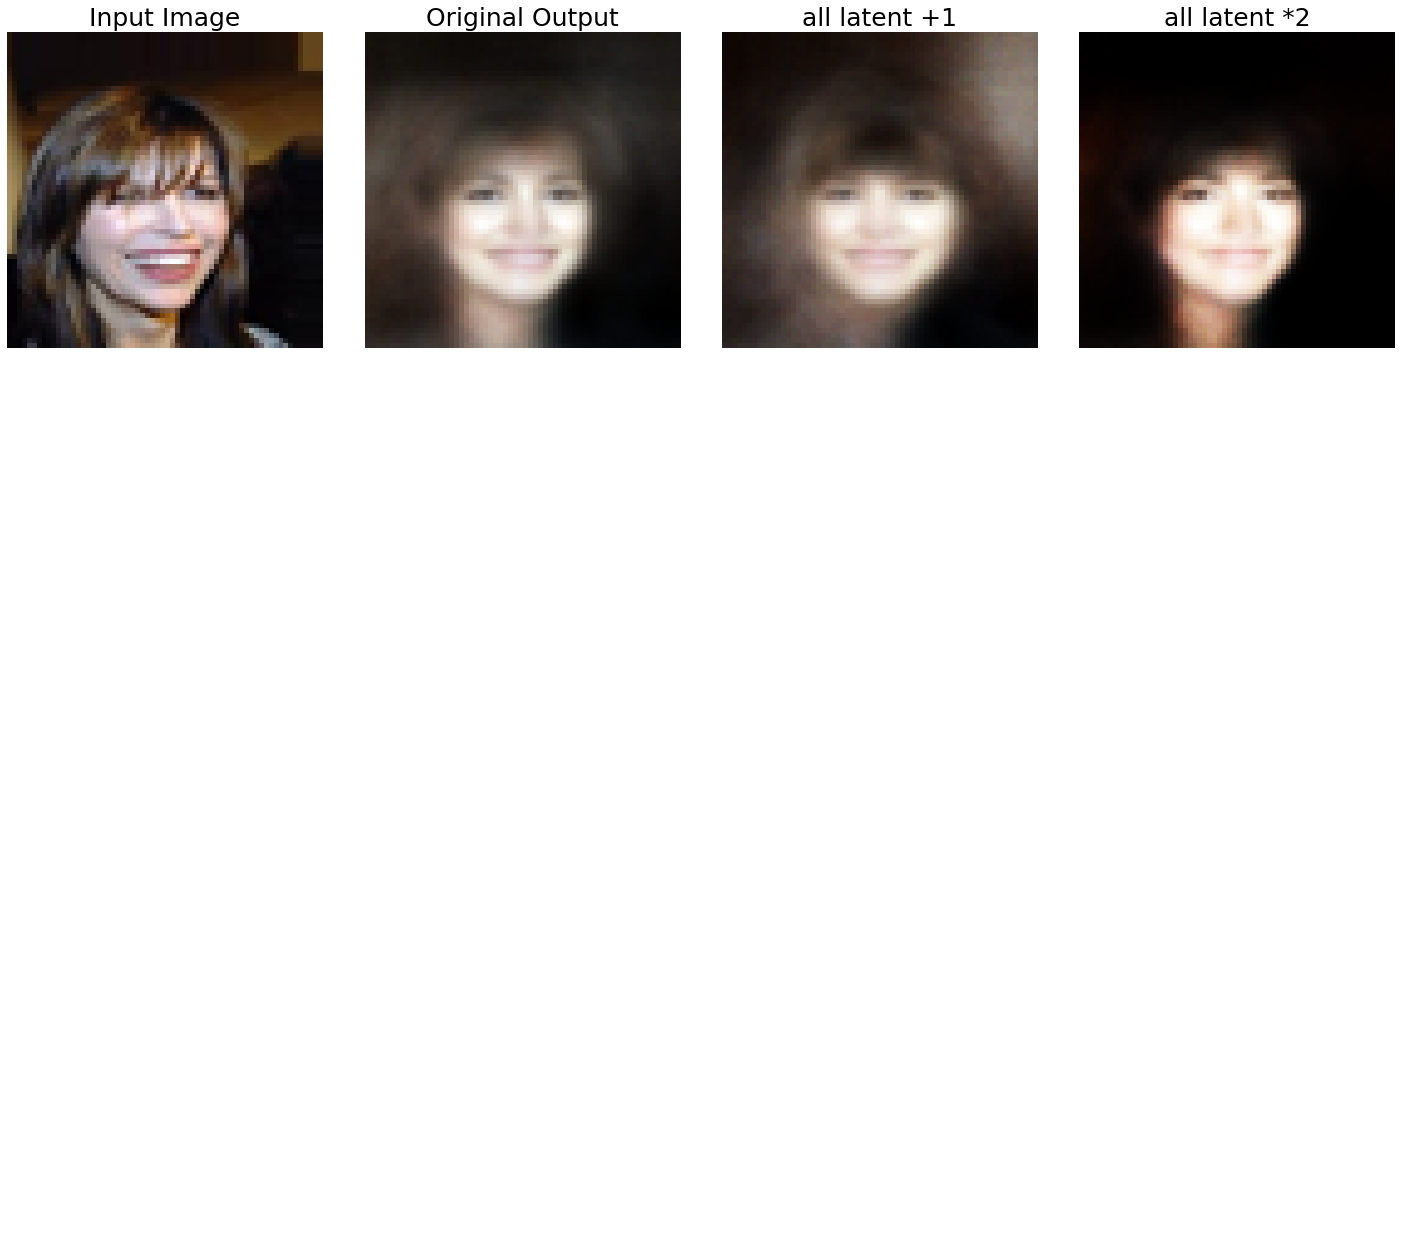

In [7]:
train = np.load('data/trainingset.npy', allow_pickle=True)
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)
train_dataloader = DataLoader(train_dataset, batch_size=1)

model = fcn_autoencoder()

# load trained model
checkpoint_path = 'report.pt'
model = torch.load(checkpoint_path)
model.eval()

# 
unloader = transforms.ToPILImage() # [0.0, 1.0]

# 
for i_tensor in train_dataloader:
    i_tensor = i_tensor.float().cuda()
    i_tensor = i_tensor.view(i_tensor.shape[0], -1)
    o_tensor = model(i_tensor)
    # Alter representation 
    a_tensor = model.encoder(i_tensor)
    a_tensor = a_tensor + 1 
    a_tensor = model.decoder(a_tensor)
    # b-type alter
    b_tensor = model.encoder(i_tensor)
    b_tensor = b_tensor * 2 
    b_tensor = model.decoder(b_tensor)
    break
print(f"a_tensor = {a_tensor.shape}")
# 

i_img = to_image(i_tensor)
o_img = to_image(o_tensor)
a_img = to_image(a_tensor)
b_img = to_image(b_tensor)

fig, ax = plt.subplots(2, 4, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
# 
ax[0, 0].set_title("Input Image", fontsize=25)
ax[0, 0].imshow(i_img)
# 
ax[0, 1].set_title("Original Output", fontsize=25)
ax[0, 1].imshow(o_img)
# 
ax[0, 2].set_title("all latent +1", fontsize=25)
ax[0, 2].imshow(a_img)
# 
ax[0, 3].set_title("all latent *2", fontsize=25)
ax[0, 3].imshow(b_img)


